In [22]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(1):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)


from src import decode_moddeling, prefill_moddeling

from variables import *

In [23]:
## Library and inputs
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

import plotnine as p9
from plotnine import ggplot, aes, geom_point, geom_line, labs, element_text

In [24]:
# This will reload the imported modules (e.g. src.analysis, src.model) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PERFILL BAtch scaling

In [25]:
data = []

for batch_size in range(1,500,2):
        try:
                prefill_outputs = prefill_moddeling(model = 'llama_7b', batch_size = batch_size,
                                                input_tokens = 2048, output_tokens = 256, FLAT = True,
                                                system_name = 'A100-80GB', bits='int8',
                                                tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                prefill_latency =  (prefill_outputs['Latency'])/1000
                prefill_throughput = batch_size/prefill_latency
                data.append([batch_size, prefill_latency, prefill_throughput] + prefill_outputs['Runtime_breakdown'])
        except ValueError:
                pass
            
data_df = pd.DataFrame(data, columns = ['Batch', 'Latency(s)', 'Query/s', 'GEMM time', 'SA time', 'Comm. time'])
data_df = data_df.replace(Model_list, Model_names_in_plot)

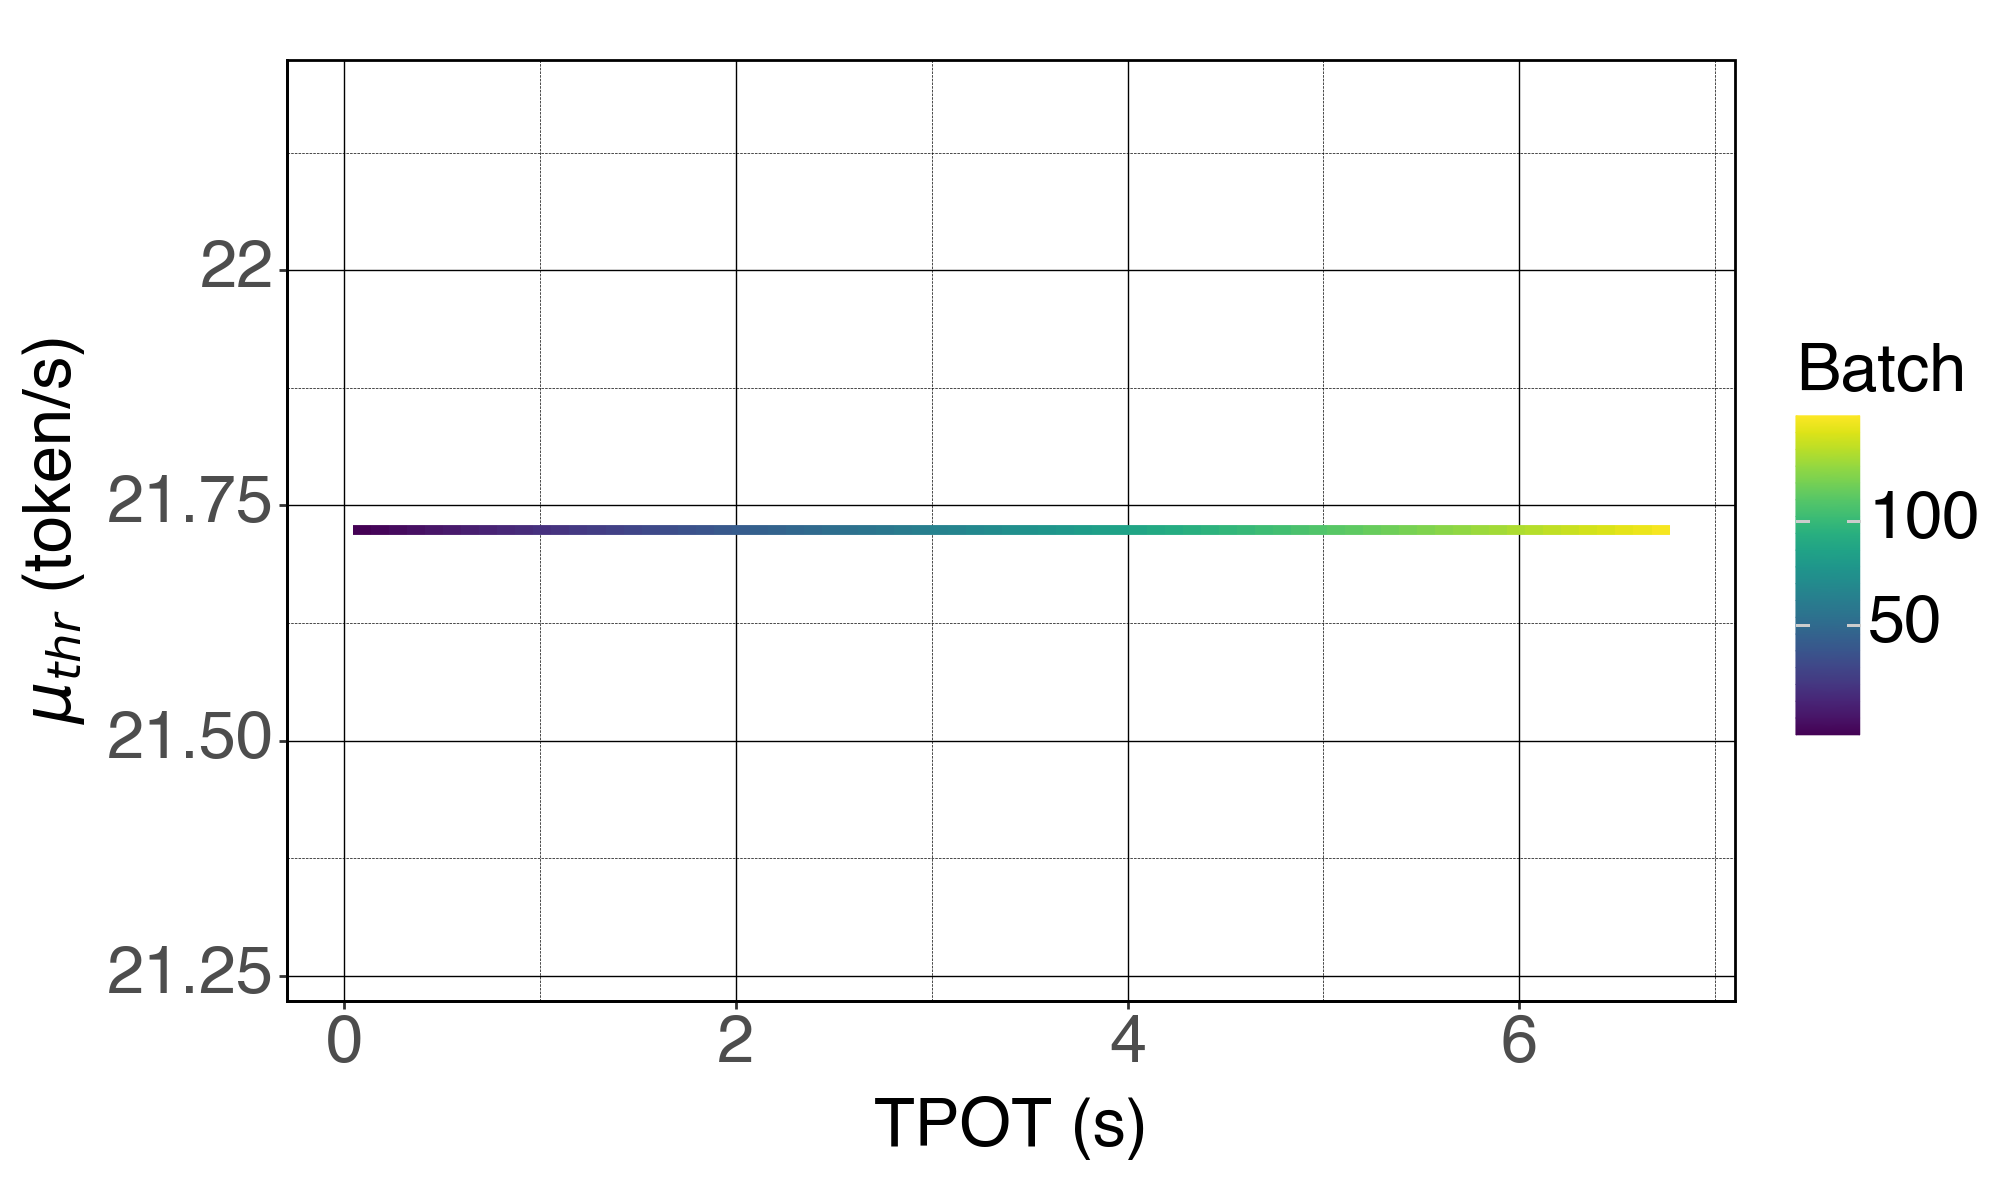

In [26]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
data_df['Batch'] = data_df['Batch'].astype(int)
p1 = (
    p9.ggplot(data_df, p9.aes(x='Latency(s)', y='Query/s'))
    + p9.geom_line(p9.aes(x='Latency(s)', y='Query/s', color='Batch'),size=2) # line plot
    # + p9.geom_point(p9.aes(shape = 'Batch'),size=3) # line plot
    + p9.labs(x='TPOT (s)', y='$\\mu_{thr}$ (token/s)')
    + plot_theme
    + p9.theme(figure_size=(10, 6))

)
print(p1)

## Decode Batch Scaling

In [27]:
data = []

for batch_size in [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20, 22, 24, 26, 28, 30, 32, 36, 38, 40, 44,]:
        try:
                decode_outputs = decode_moddeling(model = 'Mixtral_7x8', batch_size = batch_size, Bb = 4 ,
                                                input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                system_name = 'A100-80GB', bits='int8',
                                                tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                decode_latency =  (decode_outputs['Latency'])/1000
                decode_throughput = batch_size/decode_latency
                data.append([batch_size, decode_latency, decode_throughput] + decode_outputs['Runtime_breakdown'])
        except ValueError:
                pass
            
data_df = pd.DataFrame(data, columns = ['Batch', 'Latency(s)', 'Query/s', 'GEMM time', 'SA time', 'Comm. time'])
data_df = data_df.replace(Model_list, Model_names_in_plot)

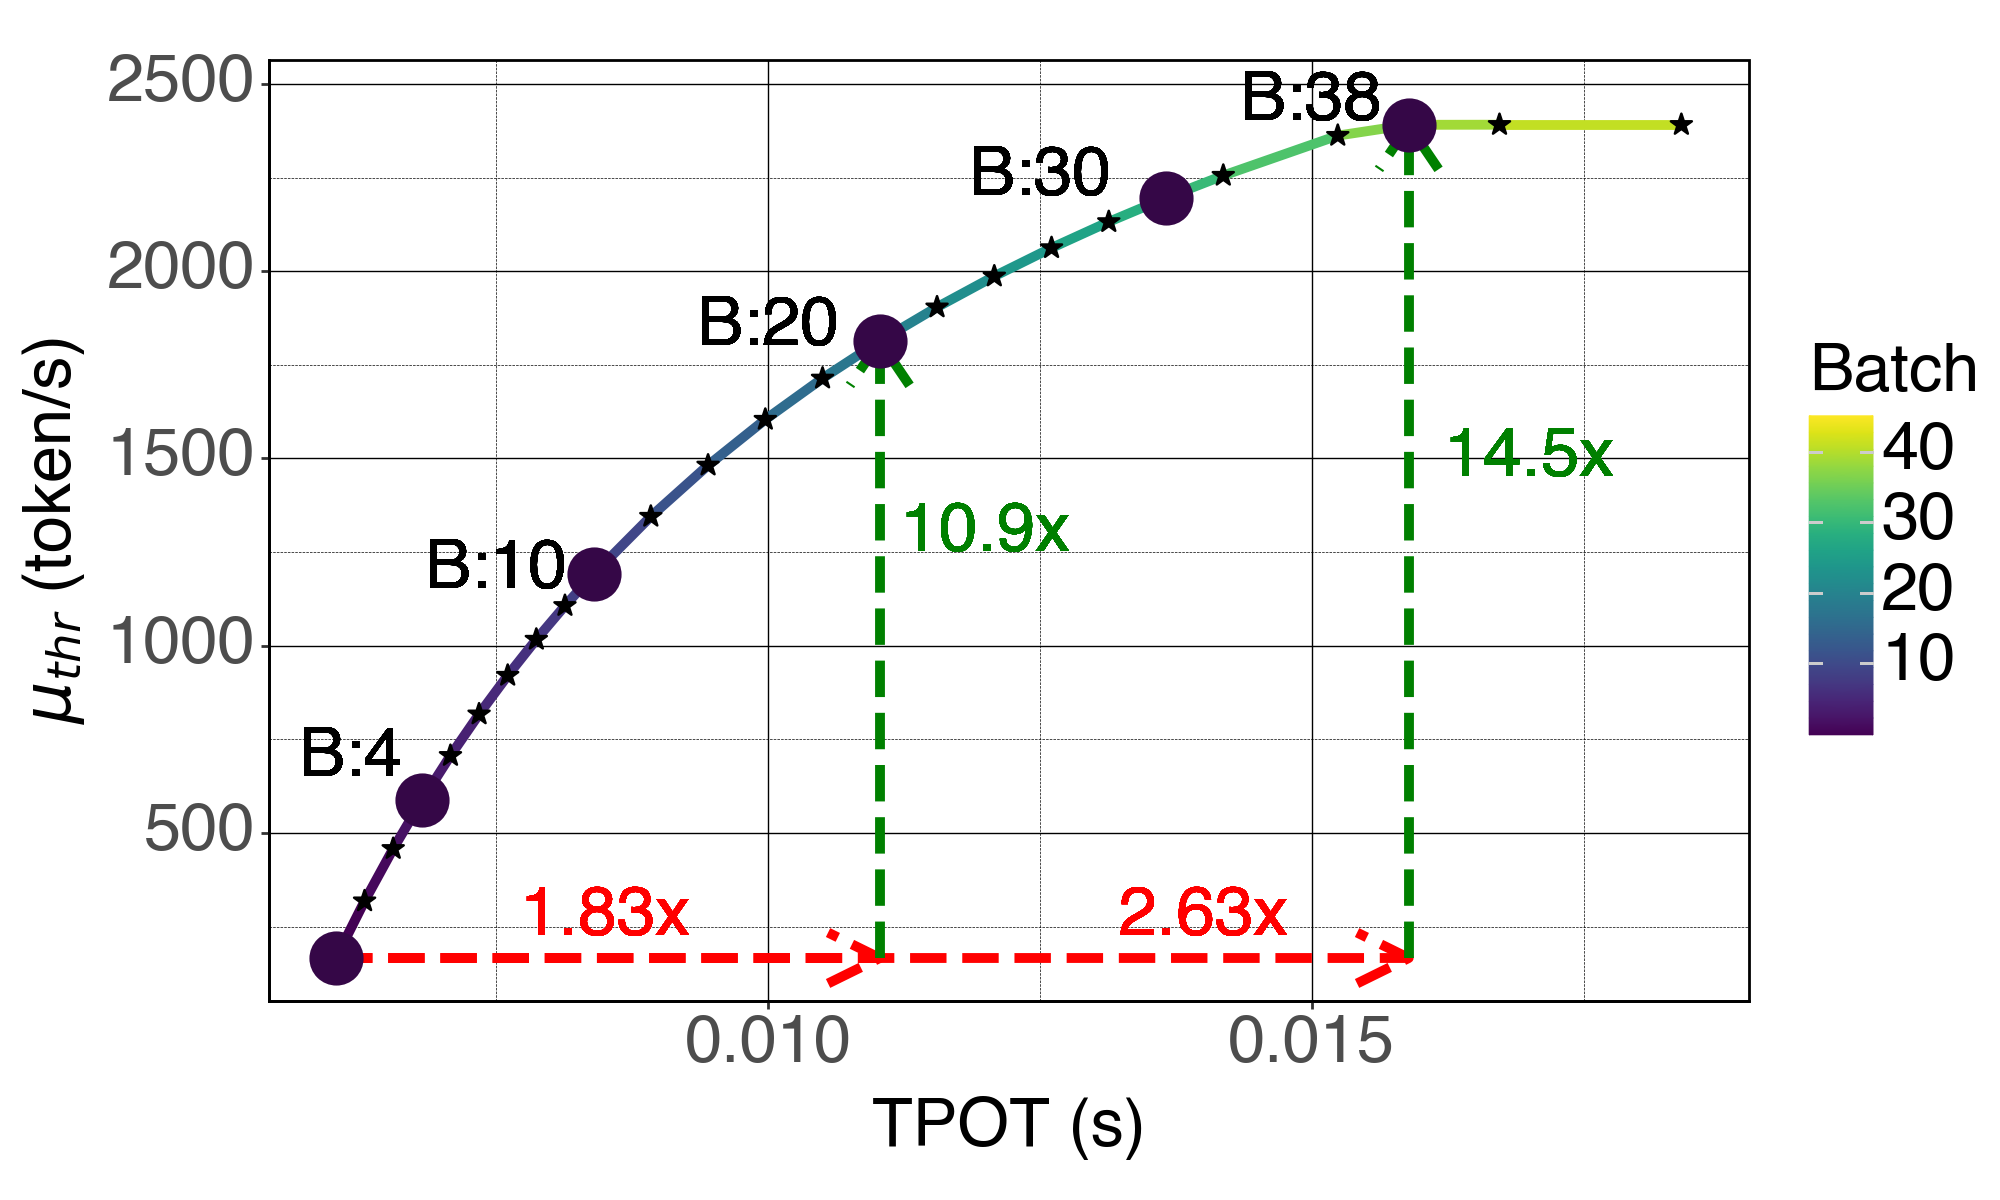

In [28]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
data_df['Batch'] = data_df['Batch'].astype(int)
p1 = (
    p9.ggplot(data_df, p9.aes(x='Latency(s)', y='Query/s'))
    + p9.geom_line(p9.aes(x='Latency(s)', y='Query/s', color='Batch'),size=2) # line plot
    + p9.geom_point(p9.aes(), color='black',size=4, shape='*') # line plot
    + p9.labs(x='TPOT (s)', y='$\\mu_{thr}$ (token/s)')
    + plot_theme
    + p9.theme(figure_size=(10, 6))
    # + p9.scale_x_log10()
    + p9.geom_segment(pd.DataFrame({'x': [0.006026], 'y': [166], 'xend': [0.015892], 'yend': [166]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red', linetype='dashed')
    + p9.geom_segment(pd.DataFrame({'x': [0.015892], 'y': [166], 'xend': [0.015892], 'yend': [2390]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='green', linetype='dashed')
    + p9.geom_text(p9.aes(x = 0.017, y = 1500),label = f" 14.5x ",color='green', size=25)
    + p9.geom_text(p9.aes(x = 0.014, y = 275),label = f" 2.63x ",color='red', size=25)


    + p9.geom_segment(pd.DataFrame({'x': [0.006026], 'y': [166], 'xend': [0.011027], 'yend': [166]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red', linetype='dashed')
    + p9.geom_segment(pd.DataFrame({'x': [0.011027], 'y': [166], 'xend': [0.011027], 'yend': [1813]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='green', linetype='dashed')
    + p9.geom_text(p9.aes(x = 0.012, y = 1300),label = f" 10.9x ",color='green', size=25)
    + p9.geom_text(p9.aes(x = 0.0085, y = 275),label = f" 1.83x ",color='red', size=25)

    # B = 1
    + p9.geom_point(data_df.query('Batch == 1'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot
    + p9.geom_text(p9.aes(x = 0.00616, y = 700), label = f"B:4", size=25) # line plot
    + p9.geom_point(data_df.query('Batch == 4'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot
    + p9.geom_text(p9.aes(x = 0.0075, y = 1200), label = f"B:10", size=25) # line plot
    + p9.geom_point(data_df.query('Batch == 10'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot
    + p9.geom_text(p9.aes(x = 0.010, y = 1850), label = f"B:20", size=25) # line plot
    + p9.geom_point(data_df.query('Batch == 20'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot
    + p9.geom_text(p9.aes(x = 0.0125, y = 2250), label = f"B:30", size=25) # line plot
    + p9.geom_point(data_df.query('Batch == 30'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot
    + p9.geom_text(p9.aes(x = 0.015, y = 2450), label = f"B:38", size=25) # line plot
    + p9.geom_point(data_df.query('Batch == 38'), p9.aes(x='Latency(s)', y='Query/s'),size=10, color='#350747', shape='o') # line plot


)
print(p1)


## Model Scaling

In [29]:
data = []

for model in Model_list:
        for batch_size in [1,5,10,15,25,40]:
                try:
                        prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                                        input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                        system_name = 'GH200', bits='int8',
                                                        tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                        decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                                        input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                        system_name = 'GH200', bits='int8',
                                                        tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                        serving_latency =  (prefill_outputs['Latency'] + 256*decode_outputs['Latency'])/1000
                        serving_throughput = batch_size/serving_latency
                        data.append([model,batch_size, serving_latency, serving_throughput] + decode_outputs['Runtime_breakdown'])
                except ValueError:
                        pass
            
data_df = pd.DataFrame(data, columns = ['Model', 'Batch', 'Latency(s)', 'Query/s', 'GEMM time', 'SA time', 'Comm. time'])
            
data_df = data_df.replace(Model_list, Model_names_in_plot)

In [30]:
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Batch'] = pd.Categorical(data_df['Batch'], categories=list(data_df['Batch'].unique()))

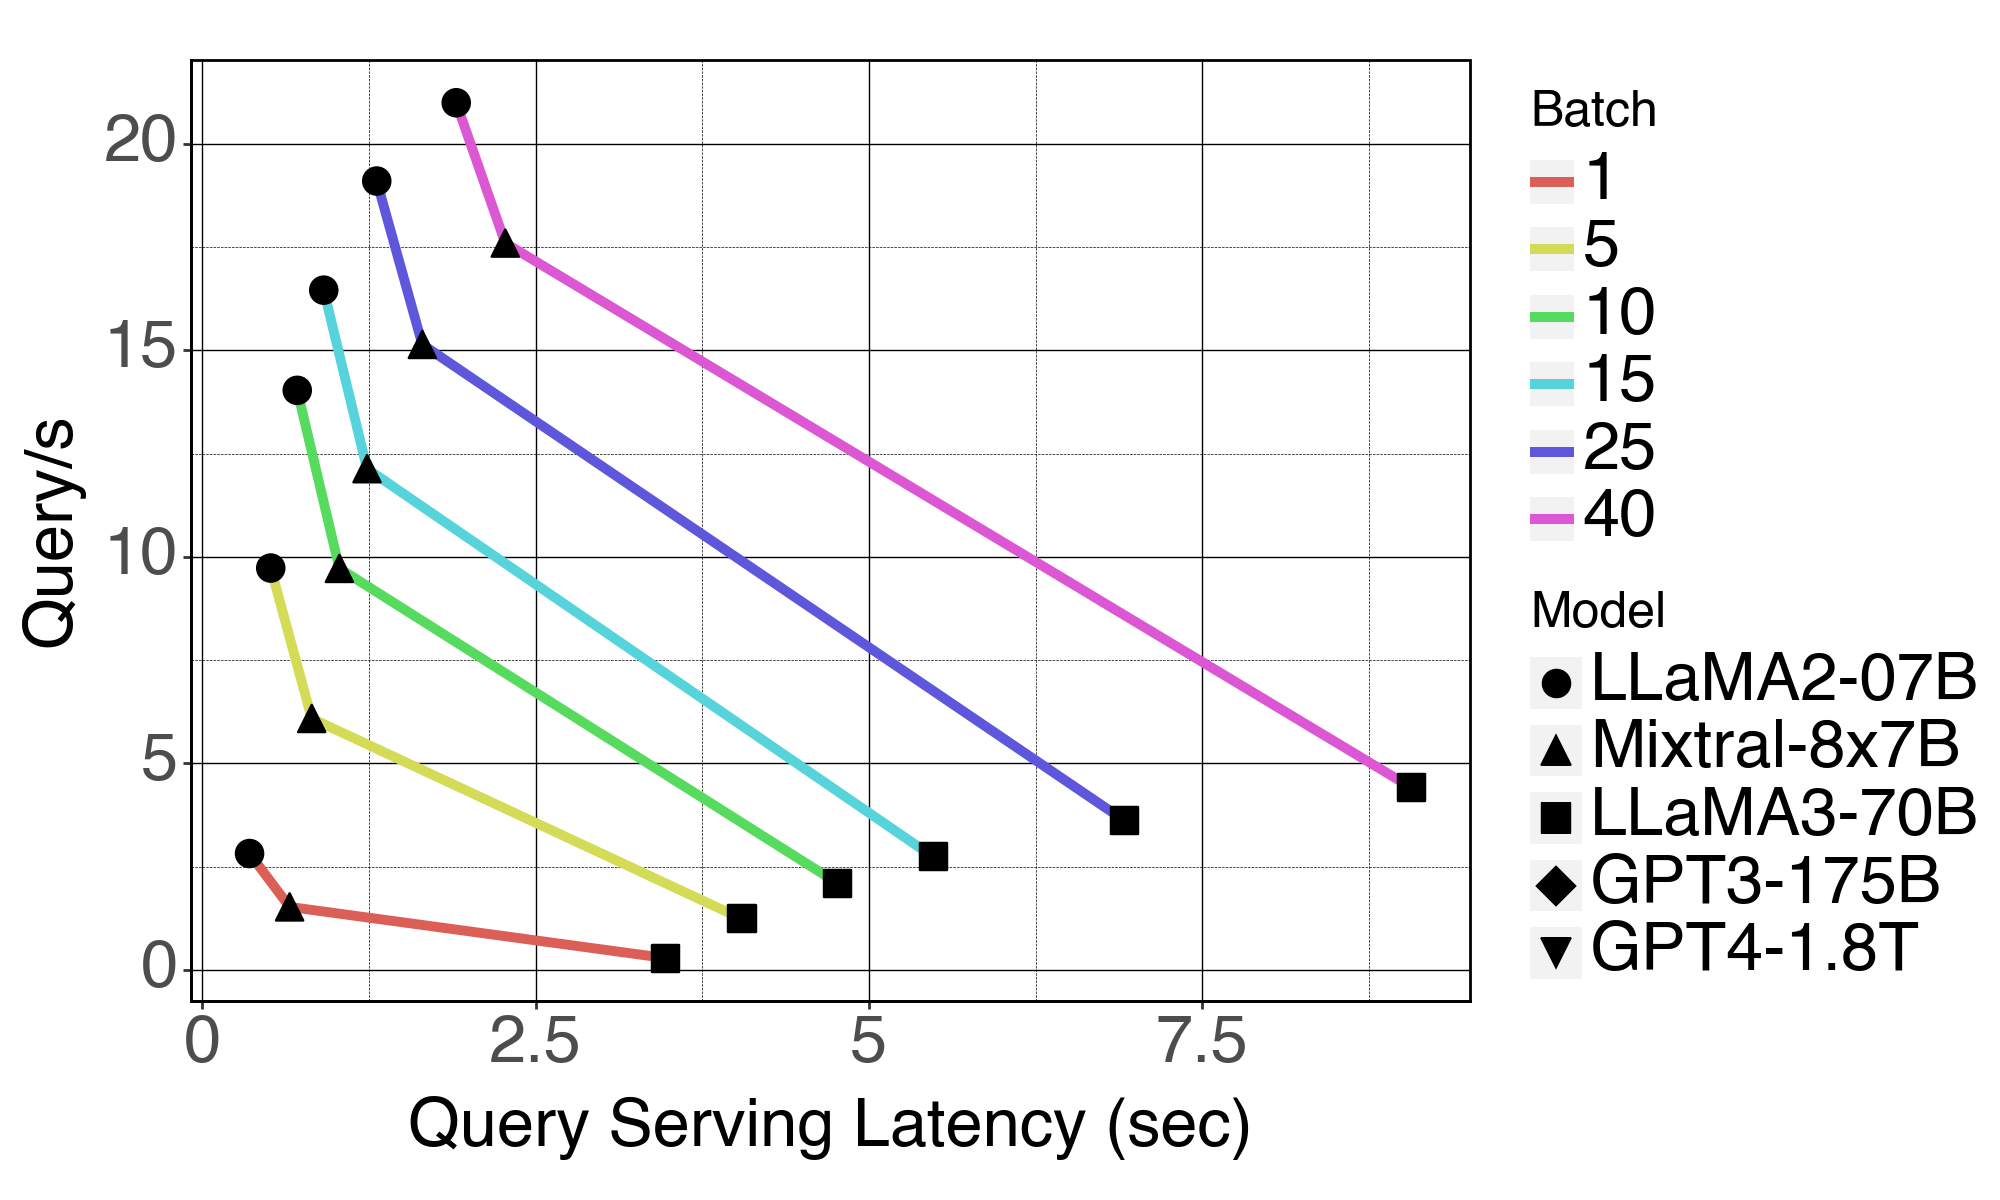

In [31]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
p1 = (
    p9.ggplot(data_df, p9.aes(x='Latency(s)', y='Query/s'))
    + p9.geom_line(p9.aes(color='Batch'),size=2) # line plot
    + p9.geom_point(p9.aes( shape = 'Model'),size=5) # line plot
    + p9.labs(x='Query Serving Latency (sec)', y='Query/s')
    + plot_theme
    + p9.theme(legend_title=p9.element_text(size=18,margin={'b': 10}),
               figure_size=(10, 6))
)
print(p1)


## Beam Size Scaling


In [32]:
data = []

for model in Model_list:
    for batch_size in range(1,40):
        for beam_size in [1,2,4,8]:
            try:
                    prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                                    input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = beam_size ,
                                                    input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    serving_latency =  (prefill_outputs['Latency'] + 256*decode_outputs['Latency'])/1000
                    serving_throughput = batch_size/serving_latency
                    data.append([model, beam_size, batch_size, serving_latency, serving_throughput, (decode_outputs['Latency'])/1000] + decode_outputs['Runtime_breakdown'])
            except ValueError:
                    pass
data_df = pd.DataFrame(data, columns = ['Model','# Beams', 'Batch', 'Latency(s)',  'Query/s','TPOT',  'GEMM time', 'SA time', 'Comm. time'])
            
data_df = data_df.replace(Model_list, Model_names_in_plot)
data_df['# Beams'] = data_df['# Beams'].astype('str')

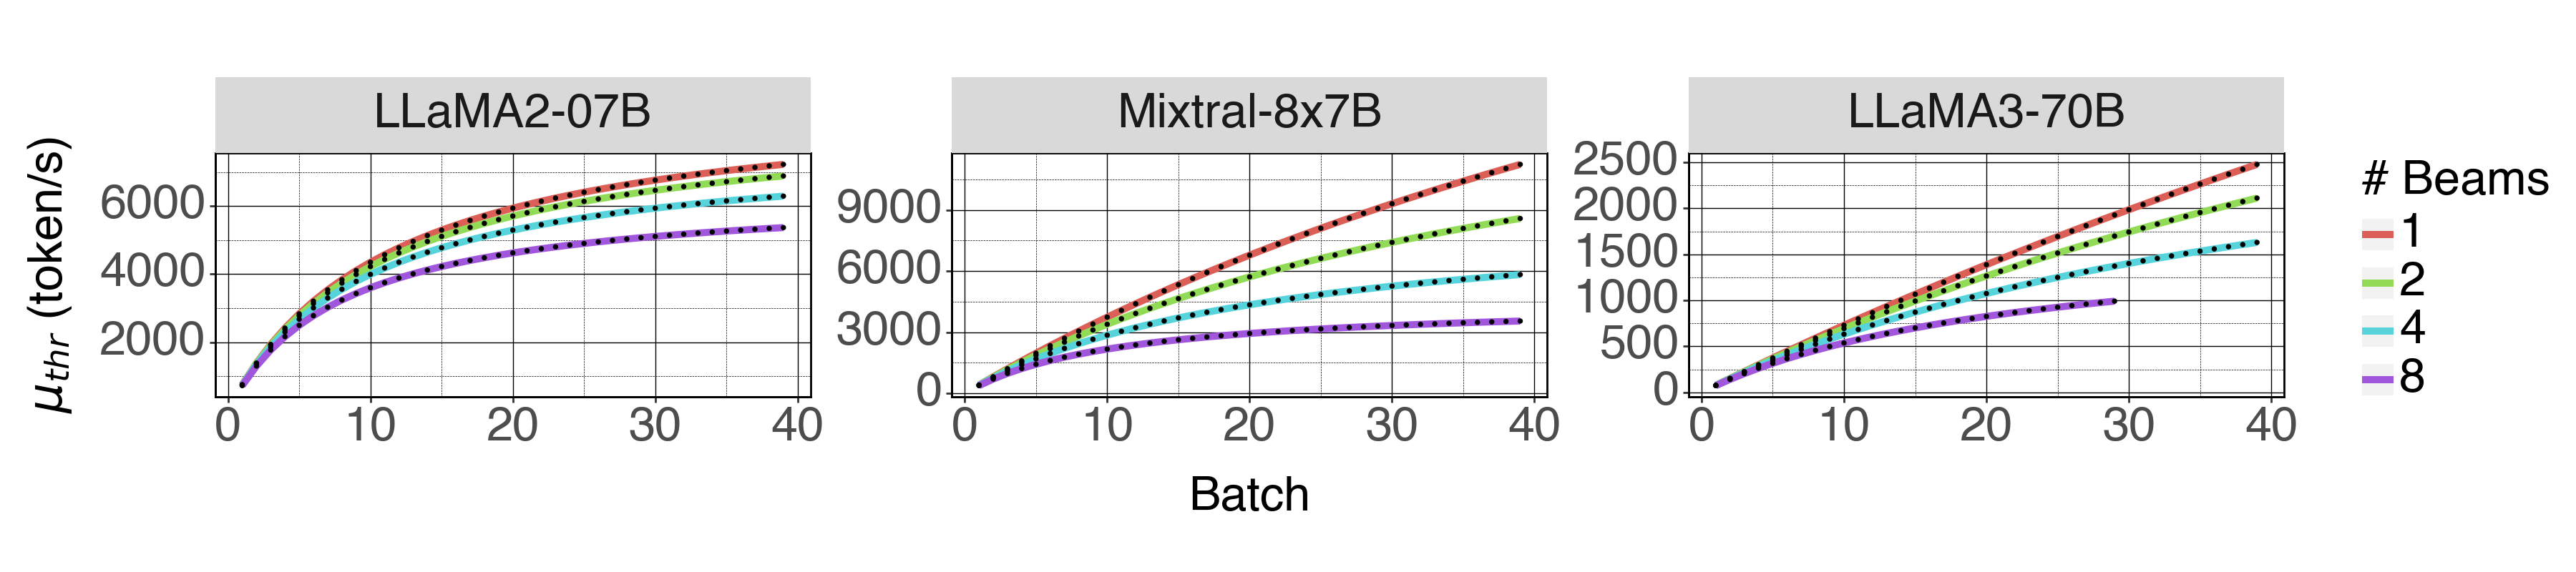

In [33]:
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df['$\\mu_{thr}$ (token/s)'] = data_df['Batch']/data_df['TPOT']
p1 = (
    p9.ggplot(data_df, p9.aes(x='Batch', y='$\\mu_{thr}$ (token/s)'))
    + p9.geom_line(p9.aes( color='# Beams'),size=2) # line plot
    + p9.geom_point(p9.aes(), color='black',size=0.5) # line plot

    + plot_theme
    + p9.theme(figure_size=(18, 4))
    + p9.facet_wrap("~ Model ", scales = 'free', ncol=5)

)
print(p1)


## Input Tokens Scaling

In [34]:
data = []

for model in Model_list:
    for input_len in range(2000,8500,2000):
        for batch_size in range(1,40):
            try:
                    prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                                    input_tokens = input_len, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                                    input_tokens = input_len, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    serving_latency =  (prefill_outputs['Latency'] + 256*decode_outputs['Latency'])/1000
                    serving_throughput = batch_size/serving_latency
                    data.append([model, input_len, batch_size, serving_latency, serving_throughput] + decode_outputs['Runtime_breakdown'])
            except ValueError:
                    pass
            
data_df = pd.DataFrame(data, columns = ['Model','Input Tokens', 'Batch', 'Latency(s)', 'Query/s', 'GEMM time', 'SA time', 'Comm. time'])
            
data_df = data_df.replace(Model_list, Model_names_in_plot)
data_df['Input Tokens'] = data_df['Input Tokens'].astype('str')

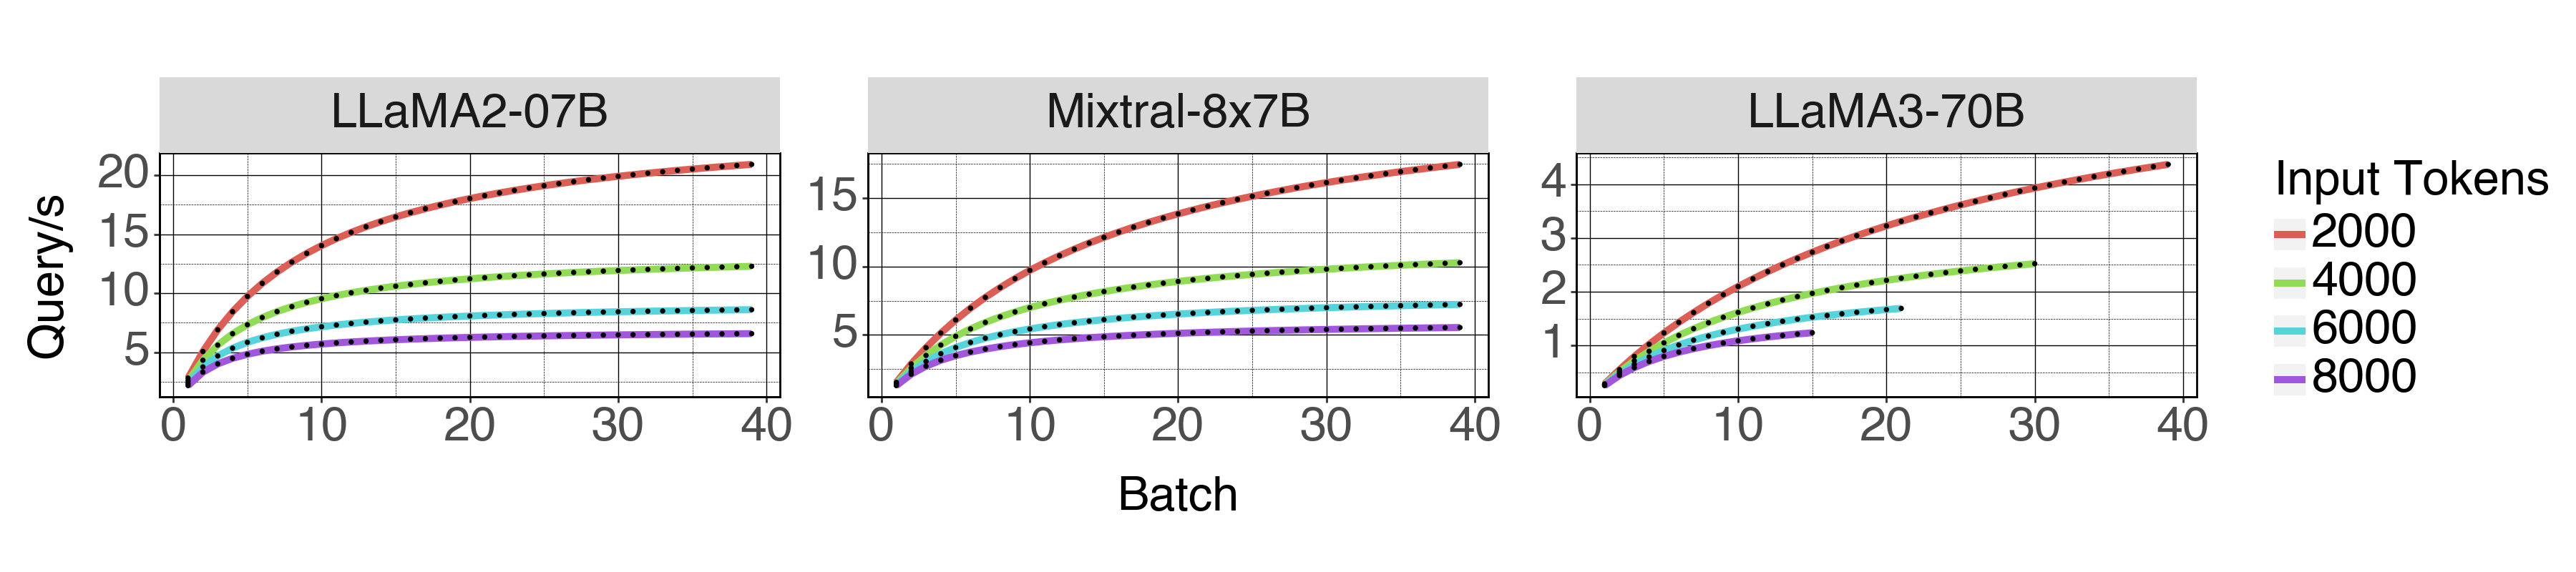

In [35]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
p1 = (
    p9.ggplot(data_df, p9.aes(x='Batch', y='Query/s'))
    + p9.geom_line(p9.aes(color='Input Tokens'),size=2) # line plot
    + p9.geom_point(p9.aes(), color='black',size=0.5) # line plot
    + plot_theme
    + p9.theme(figure_size=(18, 4))
    + p9.facet_wrap("~ Model ", scales = 'free', ncol=4)


)
print(p1)


In [36]:
for model, target_latency in zip(data_df['Model'].unique(),[0.8,1, 3, 8]):
    df = data_df[data_df['Model'] == model]
    # Calculate absolute difference between latency and target latency
    df['Latency Difference'] = abs(df['Latency(s)'] - target_latency)

    # Find the row with minimum absolute difference for each memory bandwidth value
    min_diff_idx = df.groupby('Input Tokens')['Latency Difference'].idxmin()

    # Retrieve QPS values for each memory bandwidth where latency is nearest to the target latency
    iso_latency_data = []
    for bw in min_diff_idx.keys():
        row = df[df['Input Tokens'] == bw].loc[min_diff_idx[bw], ['Input Tokens','Latency(s)', 'Query/s']].to_list()
        iso_latency_data.append(row)

    iso_latency_df = pd.DataFrame(iso_latency_data, columns=['Input Tokens','Latency(s)', 'Query/s'])

    maximum_qps = max(iso_latency_df['Query/s'])
    iso_latency_df['Performance Reduction(%)'] = 100 - 100*iso_latency_df['Query/s'] /maximum_qps 
    iso_latency_df.sort_values(by='Performance Reduction(%)')
    print(model)
    display(iso_latency_df)

LLaMA2-07B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1916184308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Input Tokens,Latency(s),Query/s,Performance Reduction(%)
0,2000,0.792106,15.149478,0.000000
1,4000,0.828593,8.448059,44.235312
2,6000,0.747559,5.350748,64.680314
3,8000,0.746899,4.016606,73.486835


Mixtral-8x7B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1916184308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Input Tokens,Latency(s),Query/s,Performance Reduction(%)
0,2000,0.987162,9.117041,0.000000
1,4000,1.021501,4.894759,46.311979
2,6000,0.981832,3.055513,66.485697
3,8000,0.943554,2.119647,76.750718


LLaMA3-70B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1916184308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Input Tokens,Latency(s),Query/s,Performance Reduction(%)
0,2000,3.474128,0.287842,0.000000
1,4000,3.616083,0.276542,3.925662
2,6000,3.763367,0.265719,7.685656
3,8000,3.915950,0.255366,11.282633


## Output Tokens Scaling


In [37]:
decode_outputs = decode_moddeling(model = 'llama_7b', batch_size = 20, Bb = 4 ,
                                                    input_tokens = 2000, output_tokens = 2000, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 

/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:212: UserWarning: Error in latency calc. Avg Decode Latency:7.259531864503613 msec , Latency based on last token : 11.255971341987316 msec, 
 Attn time:9.991098693709255; Linear time:1.2648726482780612; AR time:0; Pipeline Comm time:0.0


In [38]:
data = []

for model in Model_list:
    for output_len in [256, 512, 1024, 2048]:
        for batch_size in range(1,40):
            try:
                    prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                                    input_tokens = 2000, output_tokens = output_len, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                                    input_tokens = 2000, output_tokens = output_len, FLAT = True,
                                                    system_name = 'GH200', bits='fp8',
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    serving_latency =  (prefill_outputs['Latency'] + output_len*decode_outputs['Latency'])/1000
                    serving_throughput = batch_size/serving_latency
                    data.append([model, output_len, batch_size, serving_latency, serving_throughput, decode_outputs['Latency']/1000] + decode_outputs['Runtime_breakdown'])
            except ValueError:
                    print('')
            
data_df = pd.DataFrame(data, columns = ['Model','Generated Tokens', 'Batch', 'Latency(s)', 'Query/s', 'Latency/token(s)' , 'GEMM time', 'SA time', 'Comm. time'])
            
data_df = data_df.replace(Model_list, Model_names_in_plot)
data_df['Generated Tokens'] = data_df['Generated Tokens'].astype('str')

/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:212: UserWarning: Error in latency calc. Avg Decode Latency:4.905586086973852 msec , Latency based on last token : 7.360969802960246 msec, 
 Attn time:6.109699275217899; Linear time:1.2512705277423468; AR time:0; Pipeline Comm time:0.0
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:212: UserWarning: Error in latency calc. Avg Decode Latency:5.211812648643442 msec , Latency based on last token : 7.871811674295369 msec, 
 Attn time:6.618840881486058; Linear time:1.2529707928093112; AR time:0; Pipeline Comm time:0.0
/Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/GenZ/src/LLM_inference/llm_decode.py:212: UserWarning: Error in latency calc. Avg Decode Latency:5.51803921031303 msec , Latency based on last token : 8.38265354563049 msec, 
 Attn time:7.127982487754215; Linear time:1.2546710578762754; AR time:0; Pipeline

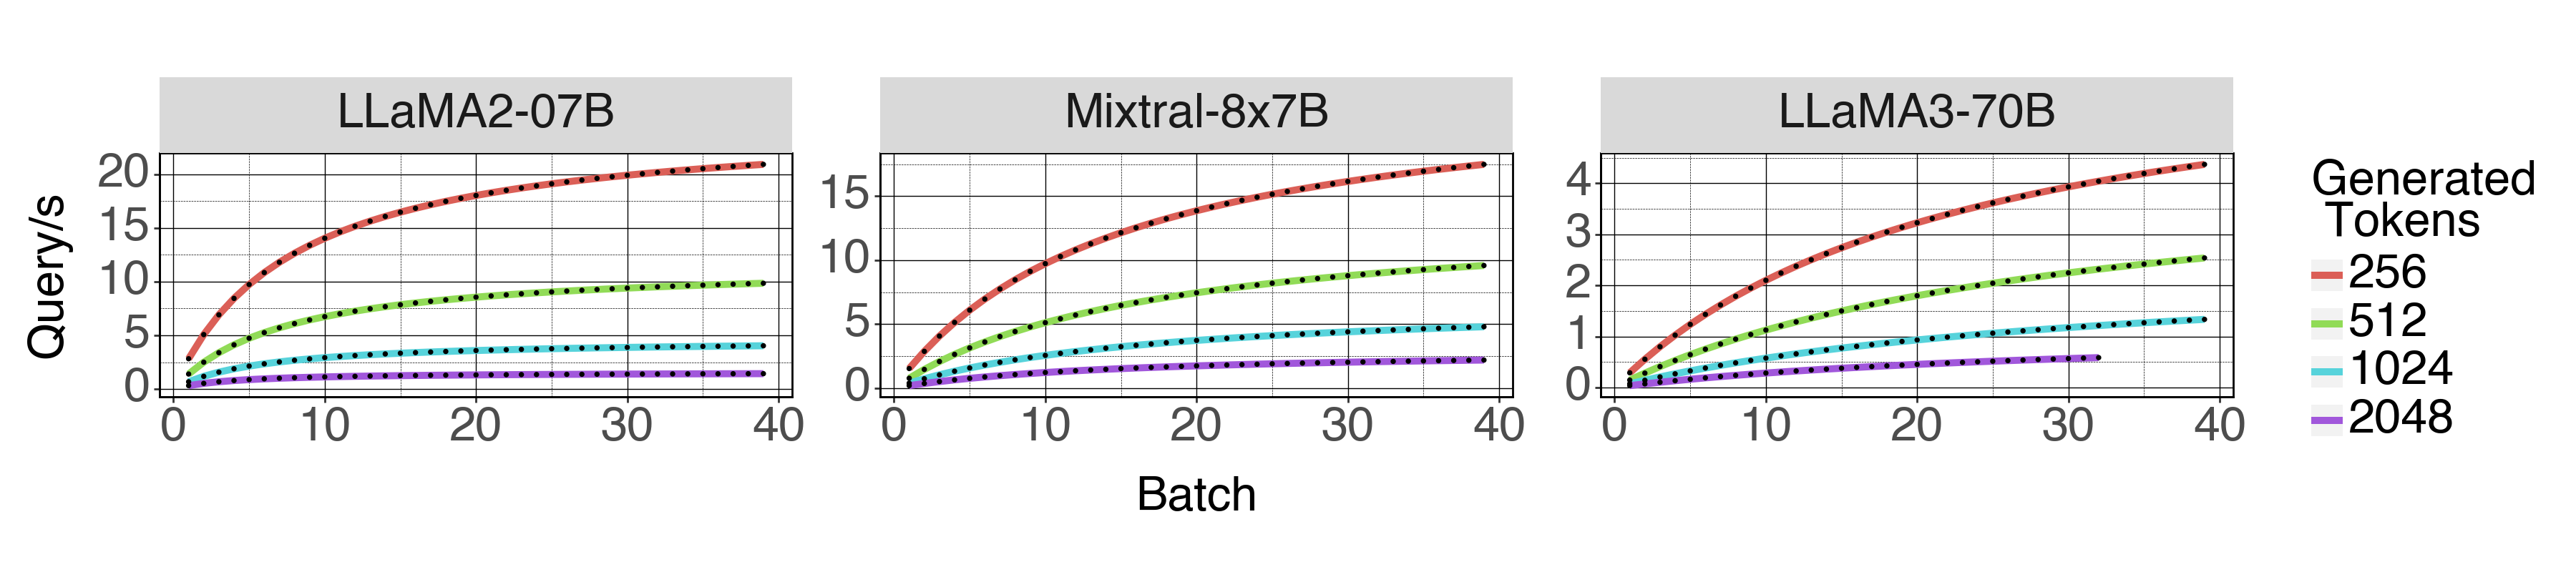

In [39]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df['Generated \n Tokens \n'] = pd.Categorical(data_df['Generated Tokens'], categories=list(data_df['Generated Tokens'].unique()))

p1 = (
    p9.ggplot(data_df, p9.aes(x='Batch', y='Query/s'))
    + p9.geom_line(p9.aes(color = 'Generated \n Tokens \n'),size=2) # line plot
        + p9.geom_point(p9.aes(), color='black',size=0.5) # line plot
    # + p9.geom_point(p9.aes( shape = 'Generated Tokens'),size=4) # line plot
    # + p9.labs(x='Latency (s)', y='Generation Throughput (token/s)')
    + plot_theme
    + p9.theme(figure_size=(18, 4))
    # + p9.scale_x_log10()
    + p9.facet_wrap("~ Model ", scales = 'free', ncol=4)


)
print(p1)


In [40]:
for model, target_latency in zip(data_df['Model'].unique(),[0.002,0.003, 0.011, 0.0225]):
    df = data_df[data_df['Model'] == model]
    # Calculate absolute difference between latency and target latency
    df['Latency Difference'] = abs(df['Latency/token(s)'] - target_latency)

    # Find the row with minimum absolute difference for each memory bandwidth value
    min_diff_idx = df.groupby('Generated Tokens')['Latency Difference'].idxmin()

    # Retrieve QPS values for each memory bandwidth where latency is nearest to the target latency
    iso_latency_data = []
    for bw in min_diff_idx.keys():
        row = df[df['Generated Tokens'] == bw].loc[min_diff_idx[bw], ['Generated Tokens','Latency/token(s)', 'Query/s']].to_list()
        iso_latency_data.append(row)

    iso_latency_df = pd.DataFrame(iso_latency_data, columns=['Generated Tokens','Latency/token(s)', 'Query/s'])

    maximum_qps = max(iso_latency_df['Query/s'])
    iso_latency_df['Performance Reduction(%)'] = 100 - 100*iso_latency_df['Query/s'] /maximum_qps 
    iso_latency_df.sort_values(by='Performance Reduction(%)')
    print(model)
    display(iso_latency_df)

LLaMA2-07B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/4152763039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Generated Tokens,Latency/token(s),Query/s,Performance Reduction(%)
0,1024,0.002047,1.882764,82.628227
1,2048,0.002150,0.678154,93.742854
2,256,0.001995,10.838067,0.000000
3,512,0.001995,4.728967,56.367063


Mixtral-8x7B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/4152763039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Generated Tokens,Latency/token(s),Query/s,Performance Reduction(%)
0,1024,0.003045,1.570183,74.209500
1,2048,0.003018,0.641569,89.462127
2,256,0.002948,6.088221,0.000000
3,512,0.002980,3.139742,48.429238


LLaMA3-70B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/4152763039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Generated Tokens,Latency/token(s),Query/s,Performance Reduction(%)
0,1024,0.013339,0.072829,74.698198
1,2048,0.013404,0.036334,87.377128
2,256,0.013290,0.287842,0.000000
3,512,0.013306,0.145250,49.538433


## Quantization


In [41]:
data = []
quantization_list = ['fp4', 'fp8', 'bf16']
for model in Model_list[:3]:
    for bits in quantization_list:
        for batch_size in range(1,40):
            try:
                    prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                                    input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits=bits,
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                                    input_tokens = 2000, output_tokens = 256, FLAT = True,
                                                    system_name = 'GH200', bits=bits,
                                                    tensor_parallel = 1, pipeline_parallel = 1, debug=False, time_breakdown=True, model_offload=False) 
                    serving_latency =  (prefill_outputs['Latency'] + 256*decode_outputs['Latency'])/1000
                    serving_throughput = batch_size/serving_latency
                    data.append([model, bits, batch_size, serving_latency, serving_throughput] + decode_outputs['Runtime_breakdown'])
            except ValueError as error:
                    print("ERROR:",error)
                    pass
            
data_df = pd.DataFrame(data, columns = ['Model','Data Format', 'Batch', 'Latency(s)', 'Query/s', 'GEMM time', 'SA time', 'Comm. time'])
            
data_df = data_df.replace(Model_list, Model_names_in_plot)
data_df = data_df.replace(quantization_list, ['FP4','FP8', 'BF16'])

ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:16.5234375. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:19.27734375. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:22.03125. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:24.78515625. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:27.5390625. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:30.29296875. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:33.046875. 
 System:GH200
ERROR: All params would not fit on chip. System Memory Cap:144.0 GB , Weights : 127.5 GB, KV Cache:35.80078125. 
 Syst

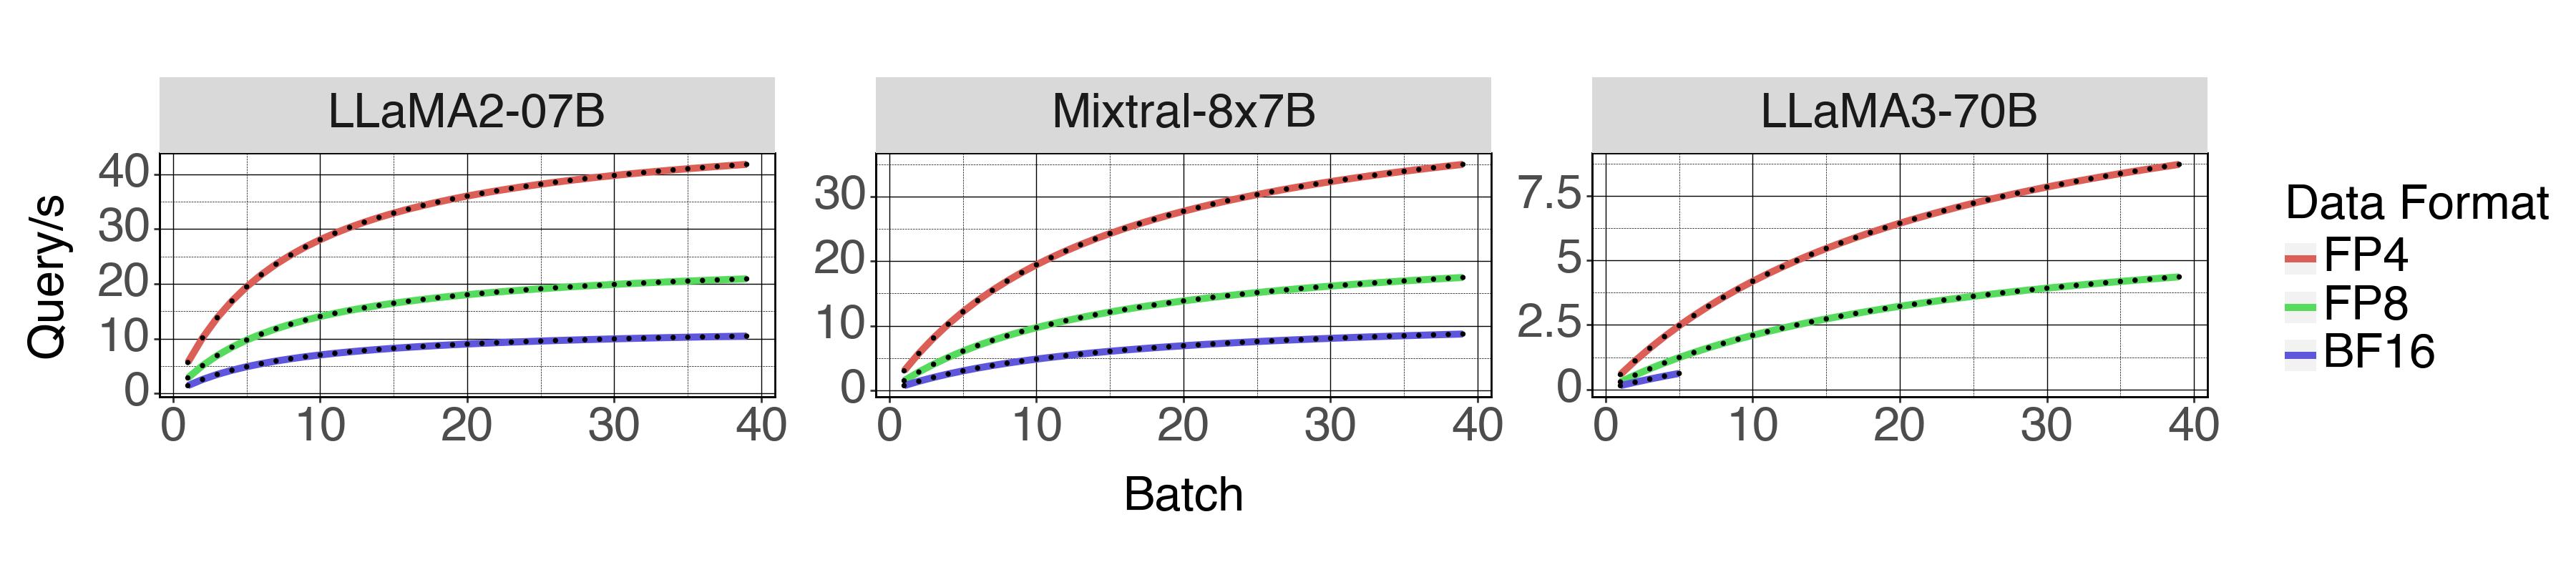

In [42]:
# data_df = pd.DataFrame(data, columns = ['Beam_merge','Batch', 'Latency(s)', 'Tokens/s', "Runtime breakdown"])
data_df['Batch'] = data_df['Batch'].astype(int)
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df['Data Format'] = pd.Categorical(data_df['Data Format'], categories=['FP4','FP8', 'BF16'])

p1 = (
    p9.ggplot(data_df, p9.aes(x='Batch', y='Query/s'))
    + p9.geom_line(p9.aes(color ='Data Format'),size=2) # line plot
    + p9.geom_point(p9.aes(), color='black',size=0.5) # line plot
    + plot_theme
    + p9.theme(figure_size=(18, 4))
    + p9.facet_wrap("~ Model ", scales = 'free', ncol=4)


)
print(p1)


In [43]:
for model, target_latency in zip(data_df['Model'].unique(),[0.5,1, 3, 6]):
    df = data_df[data_df['Model'] == model]
    # Calculate absolute difference between latency and target latency
    df['Latency Difference'] = abs(df['Latency(s)'] - target_latency)

    # Find the row with minimum absolute difference for each memory bandwidth value
    min_diff_idx = df.groupby('Data Format')['Latency Difference'].idxmin()

    # Retrieve QPS values for each memory bandwidth where latency is nearest to the target latency
    iso_latency_data = []
    for bw in min_diff_idx.keys():
        row = df[df['Data Format'] == bw].loc[min_diff_idx[bw], ['Data Format','Latency(s)', 'Query/s']].to_list()
        iso_latency_data.append(row)

    iso_latency_df = pd.DataFrame(iso_latency_data, columns=['Data Format','Latency(s)', 'Query/s'])

    maximum_qps = max(iso_latency_df['Query/s'])
    iso_latency_df['Performance Reduction(%)'] = 100 - 100*iso_latency_df['Query/s'] /maximum_qps 
    iso_latency_df.sort_values(by='Performance Reduction(%)')
    print(model)
    display(iso_latency_df)

LLaMA2-07B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Data Format,Latency(s),Query/s,Performance Reduction(%)
0,FP4,0.495429,34.313684,0.000000
1,FP8,0.513854,9.730392,71.642822
2,BF16,0.709705,1.409037,95.893660


Mixtral-8x7B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Data Format,Latency(s),Query/s,Performance Reduction(%)
0,FP4,0.991294,33.289811,0.000000
1,FP8,0.987162,9.117041,72.613118
2,BF16,1.310707,0.762947,97.708167


LLaMA3-70B


/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/h1/r_4mhdb92_7cg5n015yr61wh0000gp/T/ipykernel_55540/1306736179.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Data Format,Latency(s),Query/s,Performance Reduction(%)
0,FP4,3.028704,6.273311,0.000000
1,FP8,3.474128,0.287842,95.411641
2,BF16,6.948256,0.143921,97.705820
